In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.combine import SMOTETomek
import time
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/PGPDSE/Capstone/CSV Files/Diabetes_Preprocessed_Before_Feature_Selection.csv')
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,diabetesMed,readmitted,preceding_year_visits,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Referral,1,41,0,1,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,no_med
1,Caucasian,0,15,Discharged to home,Emergency,3,59,0,18,"Endocrine, Nutritional, Metabolic, Immunity",Diabetes,"Endocrine, Nutritional, Metabolic, Immunity",9,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
2,AfricanAmerican,0,25,Discharged to home,Emergency,2,11,5,13,"Pregnancy, Childbirth",Diabetes,External causes of injury,6,None,None,-2,-2,-2,0,-2,-2,-2,-2,1,0,3,0,other_meds
3,Caucasian,1,35,Discharged to home,Emergency,2,44,1,16,Infectious and Parasitic,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
4,Caucasian,1,45,Discharged to home,Emergency,1,51,0,8,Neoplasms,Neoplasms,Diabetes,5,None,None,-2,-2,-2,0,-2,-2,-2,0,1,0,0,0,insulin_combo


In [ ]:
df.shape

(97070, 28)

In [ ]:
X = df.drop('readmitted', 1)
y = df['readmitted']
X_dum = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.3, random_state = 0, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67949, 95), (29121, 95), (67949,), (29121,))

In [ ]:
y_train.sum()

7784

In [ ]:
67949-7784

60165

In [ ]:
weight = 60165/7784
weight

7.72931654676259

In [ ]:
model = XGBClassifier(random_state = 0, n_jobs = -1)
model.fit(X_train, y_train)
sorted(zip(model.feature_importances_, X_train.columns), reverse = True)

[(0.09763332, 'preceding_year_visits'),
 (0.074054845,
  'discharge_disposition_id_Transferred to another medical facility'),
 (0.025621982, 'insulin_treatment_insulin_only'),
 (0.02344511, 'diag_1_External causes of injury'),
 (0.022201315,
  'discharge_disposition_id_Still patient/referred to this institution'),
 (0.022033826, 'time_in_hospital'),
 (0.021746315, 'number_diagnoses'),
 (0.020897107, 'diag_1_Pregnancy, Childbirth'),
 (0.019829785, 'age'),
 (0.019209553, 'diag_1_Musculoskeletal System and Connective Tissue'),
 (0.018719388, 'diag_1_Diabetes'),
 (0.018365977, 'A1Cresult_Norm'),
 (0.01803824, 'diag_2_Neoplasms'),
 (0.017823787, 'diag_3_Neoplasms'),
 (0.016225567, 'diabetesMed'),
 (0.01615074, 'diag_3_Diabetes'),
 (0.016127516, 'race_Hispanic'),
 (0.01517793, 'diag_1_Respiratory'),
 (0.014898698, 'diag_1_Mental Disorders'),
 (0.014670946, 'diag_3_Infectious and Parasitic'),
 (0.014349018, 'admission_source_id_Referral'),
 (0.014208642,
  'discharge_disposition_id_Discharged

In [ ]:
model_cw = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = weight)
model_cw.fit(X_train, y_train)
sorted(zip(model_cw.feature_importances_, X_train.columns), reverse = True)

[(0.11015245, 'preceding_year_visits'),
 (0.09855306,
  'discharge_disposition_id_Transferred to another medical facility'),
 (0.026058724, 'number_diagnoses'),
 (0.024185466, 'diag_1_Musculoskeletal System and Connective Tissue'),
 (0.023388777, 'time_in_hospital'),
 (0.022898253, 'insulin_treatment_insulin_only'),
 (0.019844865, 'diag_1_Pregnancy, Childbirth'),
 (0.01943115, 'age'),
 (0.018074457, 'A1Cresult_Norm'),
 (0.016618093, 'race_Hispanic'),
 (0.016178304, 'diag_1_Respiratory'),
 (0.015416241, 'diabetesMed'),
 (0.015129163, 'diag_1_External causes of injury'),
 (0.014708788, 'diag_1_Circulatory'),
 (0.014585239, 'diag_2_Neoplasms'),
 (0.014162342, 'num_medications'),
 (0.01405839,
  'discharge_disposition_id_Still patient/referred to this institution'),
 (0.013878585, 'diag_2_Diabetes'),
 (0.013676609, 'number_changes'),
 (0.0134020215, 'diag_3_Diabetes'),
 (0.012482481, 'diag_1_Endocrine, Nutritional, Metabolic, Immunity'),
 (0.012310358, 'diag_1_Infectious and Parasitic'),
 

In [ ]:
X_t = X_train.copy()
X_t['random'] = np.random.randint(0, 2, X_t.shape[0])
model_random = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = weight)
model_random.fit(X_t, y_train)
sorted(zip(model_random.feature_importances_, X_t.columns), reverse = True)

[(0.11620799, 'preceding_year_visits'),
 (0.092827514,
  'discharge_disposition_id_Transferred to another medical facility'),
 (0.023756016, 'number_diagnoses'),
 (0.02261892, 'time_in_hospital'),
 (0.022391671, 'insulin_treatment_insulin_only'),
 (0.022148535, 'diag_1_Musculoskeletal System and Connective Tissue'),
 (0.022076087, 'diag_1_Pregnancy, Childbirth'),
 (0.02002753, 'age'),
 (0.016875958, 'diabetesMed'),
 (0.016655672, 'diag_1_Respiratory'),
 (0.016304092, 'diag_1_Circulatory'),
 (0.01617546, 'race_Hispanic'),
 (0.015510787, 'diag_2_Neoplasms'),
 (0.015405022, 'A1Cresult_Norm'),
 (0.015367101, 'diag_1_External causes of injury'),
 (0.0153036965, 'diag_1_Injury and Poisoning'),
 (0.014554674, 'number_changes'),
 (0.014272934,
  'discharge_disposition_id_Still patient/referred to this institution'),
 (0.0142473085, 'diag_2_Diabetes'),
 (0.014218858, 'num_medications'),
 (0.013849449, 'diag_3_Diabetes'),
 (0.013229456, 'diag_2_Pregnancy, Childbirth'),
 (0.012764656, 'diag_3_Gen

In [ ]:
fi_df = pd.DataFrame({'Features' : X_train.columns, 'Importances without CW' : model.feature_importances_,
                          'Importances with CW' : model_cw.feature_importances_})
fi_df

,Features,Importances without CW,Importances with CW
0,gender,0.012161,0.009078
1,age,0.019830,0.019431
2,time_in_hospital,0.022034,0.023389
3,num_lab_procedures,0.010906,0.009294
4,num_procedures,0.013072,0.009495
5,num_medications,0.013552,0.014162
6,number_diagnoses,0.021746,0.026059
7,metformin,0.012740,0.011863
8,repaglinide,0.012726,0.006477
9,glimepiride,0.000000,0.006581


### Without Class Weight

In [ ]:
imp = fi_df[fi_df['Importances without CW'] >= 0]['Features']
print("Number of features:", len(imp))
model = XGBClassifier(n_jobs = -1, random_state = 0)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 95
Training Time: 11.279470682144165
Prediction Time: 0.09786105155944824
Train Accuracy Score: 0.8855612297458388
Train Confusion Matrix:
 [[60164     1]
 [ 7775     9]] 

Train F1 Score: 0.0023094688221709007
Train Precision Score: 0.9
Train Recall Score: 0.0011562178828365879
Train ROC_AUC Score: 0.6704319427244826

Test Accuracy Score: 0.8856495312660966
Test Confusion Matrix:
 [[25784     1]
 [ 3329     7]] 

Test F1 Score: 0.004186602870813397
Test Precision Score: 0.875
Test Recall Score: 0.0020983213429256594
Test ROC_AUC Score: 0.6630259724739116


In [ ]:
imp = fi_df[fi_df['Importances without CW'] >= 0.01]['Features']
print("Number of features:", len(imp))
model = XGBClassifier(n_jobs = -1, random_state = 0)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 50
Training Time: 6.718195676803589
Prediction Time: 0.08240747451782227
Train Accuracy Score: 0.8855465128257958
Train Confusion Matrix:
 [[60163     2]
 [ 7775     9]] 

Train F1 Score: 0.002309172546504169
Train Precision Score: 0.8181818181818182
Train Recall Score: 0.0011562178828365879
Train ROC_AUC Score: 0.6699911873044571

Test Accuracy Score: 0.8856495312660966
Test Confusion Matrix:
 [[25783     2]
 [ 3328     8]] 

Test F1 Score: 0.004781829049611476
Test Precision Score: 0.8
Test Recall Score: 0.002398081534772182
Test ROC_AUC Score: 0.6629238959036376


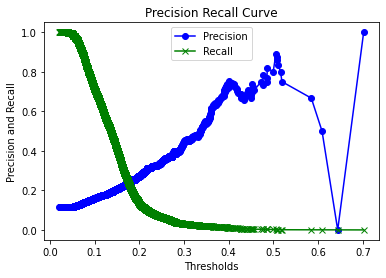

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

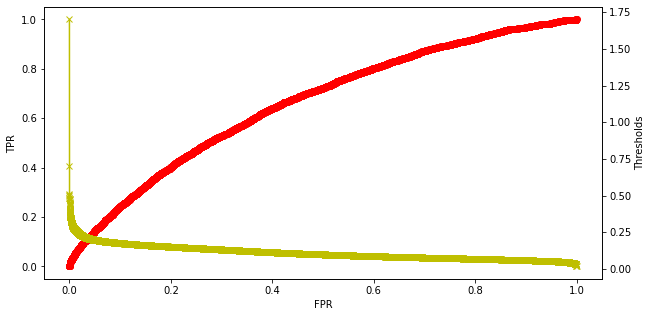

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, y_test_prob)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.536589,0.260102,0.159163,0.711031
1,0.15,0.751417,0.273703,0.205700,0.408873
2,0.20,0.859345,0.179816,0.270808,0.134592
3,0.25,0.878610,0.109347,0.342812,0.065048
4,0.30,0.884585,0.059334,0.447257,0.031775
5,0.35,0.885787,0.037058,0.542373,0.019185
6,0.40,0.886233,0.021848,0.725490,0.011091
7,0.45,0.885684,0.008341,0.666667,0.004197
8,0.50,0.885650,0.004782,0.800000,0.002398
9,0.55,0.885512,0.001796,0.750000,0.000899


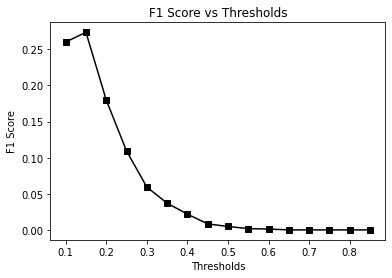

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

### With Class Weight

In [ ]:
imp = fi_df[fi_df['Importances with CW'] >= 0]['Features']
print("Number of features:", len(imp))
model = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = weight)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 95
Training Time: 11.273347616195679
Prediction Time: 0.10129594802856445
Train Accuracy Score: 0.6127242490691548
Train Confusion Matrix:
 [[36685 23480]
 [ 2835  4949]] 

Train F1 Score: 0.2733272581669566
Train Precision Score: 0.1740828027718175
Train Recall Score: 0.6357913669064749
Train ROC_AUC Score: 0.6733091366419632

Test Accuracy Score: 0.6143676384739535
Test Confusion Matrix:
 [[15812  9973]
 [ 1257  2079]] 

Test F1 Score: 0.27021055367819075
Test Precision Score: 0.17250248921340855
Test Recall Score: 0.6232014388489209
Test ROC_AUC Score: 0.6640637112183436


In [ ]:
imp = fi_df[fi_df['Importances with CW'] >= 0.01]['Features']
print("Number of features:", len(imp))
model = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = weight)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 37
Training Time: 5.4562413692474365
Prediction Time: 0.07878589630126953
Train Accuracy Score: 0.6141370733932803
Train Confusion Matrix:
 [[36865 23300]
 [ 2919  4865]] 

Train F1 Score: 0.27066121449831704
Train Precision Score: 0.17273211432629149
Train Recall Score: 0.625
Train ROC_AUC Score: 0.6678911502702956

Test Accuracy Score: 0.6163593283197693
Test Confusion Matrix:
 [[15891  9894]
 [ 1278  2058]] 

Test F1 Score: 0.2692307692307692
Test Precision Score: 0.17218875502008033
Test Recall Score: 0.6169064748201439
Test ROC_AUC Score: 0.6620772259446659


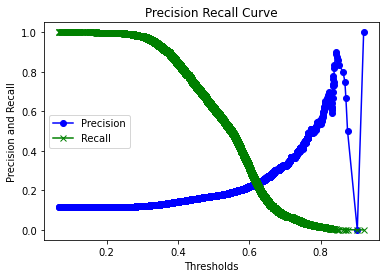

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

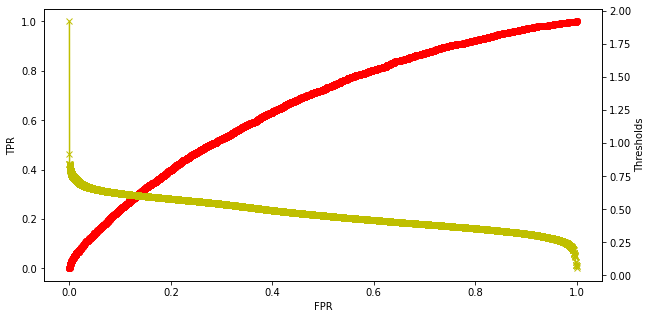

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, y_test_prob)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.116376,0.205802,0.114712,0.999400
1,0.15,0.117819,0.205971,0.114825,0.998801
2,0.20,0.121184,0.206499,0.115161,0.998201
3,0.25,0.135332,0.208425,0.116422,0.993705
4,0.30,0.179080,0.214703,0.120564,0.979616
5,0.35,0.270698,0.226077,0.128682,0.929856
6,0.40,0.401772,0.244175,0.142748,0.843525
7,0.45,0.520449,0.258482,0.157063,0.729616
8,0.50,0.616359,0.269231,0.172189,0.616906
9,0.55,0.697881,0.274691,0.189447,0.499400


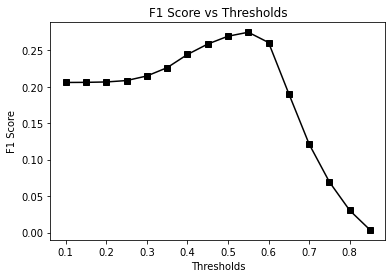

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

### Sampling Techniques

#### Under Sampling

In [ ]:
X_train.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,diabetesMed,preceding_year_visits,number_changes,race_Asian,race_Caucasian,race_Hispanic,race_Other,discharge_disposition_id_Discharged to home with home health service,discharge_disposition_id_Left AMA,discharge_disposition_id_Not Available,discharge_disposition_id_Still patient/referred to this institution,discharge_disposition_id_Transferred to another medical facility,admission_source_id_Not Available,admission_source_id_Referral,admission_source_id_Transferred from another health care facility,diag_1_Circulatory,diag_1_Congenital Anomalies,diag_1_Diabetes,diag_1_Digestive,"diag_1_Endocrine, Nutritional, Metabolic, Immunity",diag_1_External causes of injury,diag_1_Genitourinary,diag_1_Infectious and Parasitic,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Musculoskeletal System and Connective Tissue,diag_1_Neoplasms,diag_1_Nervous,diag_1_Other Symptoms,"diag_1_Pregnancy, Childbirth",diag_1_Respiratory,diag_1_Sense Organs,diag_1_Skin and Subcutaneous Tissue,diag_2_Circulatory,diag_2_Congenital Anomalies,diag_2_Diabetes,diag_2_Digestive,"diag_2_Endocrine, Nutritional, Metabolic, Immunity",diag_2_External causes of injury,diag_2_Genitourinary,diag_2_Infectious and Parasitic,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Musculoskeletal System and Connective Tissue,diag_2_Neoplasms,diag_2_Nervous,diag_2_Not Required,diag_2_Other Symptoms,"diag_2_Pregnancy, Childbirth",diag_2_Respiratory,diag_2_Sense Organs,diag_2_Skin and Subcutaneous Tissue,diag_3_Circulatory,diag_3_Congenital Anomalies,diag_3_Diabetes,diag_3_Digestive,"diag_3_Endocrine, Nutritional, Metabolic, Immunity",diag_3_External causes of injury,diag_3_Genitourinary,diag_3_Infectious and Parasitic,diag_3_Injury and Poisoning,diag_3_Mental Disorders,diag_3_Musculoskeletal System and Connective Tissue,diag_3_Neoplasms,diag_3_Nervous,diag_3_Not Required,diag_3_Other Symptoms,"diag_3_Pregnancy, Childbirth",diag_3_Respiratory,diag_3_Sense Organs,diag_3_Skin and Subcutaneous Tissue,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_treatment_insulin_only,insulin_treatment_no_med,insulin_treatment_other_meds
73921,0,45,6,53,1,29,8,-1,-2,0,-2,-2,-2,-2,-1,1,2,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
96919,0,85,2,43,0,24,7,-2,-2,-2,0,-2,-2,-2,0,1,3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
25853,1,65,1,1,1,17,3,-2,-2,-2,-2,-2,-2,-2,-2,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
31598,1,85,5,42,0,20,9,-2,-2,-2,1,-2,-2,-2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
24086,1,65,3,45,2,17,8,-2,-2,-2,-2,-2,-2,-2,-2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


In [ ]:
X_test.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,diabetesMed,preceding_year_visits,number_changes,race_Asian,race_Caucasian,race_Hispanic,race_Other,discharge_disposition_id_Discharged to home with home health service,discharge_disposition_id_Left AMA,discharge_disposition_id_Not Available,discharge_disposition_id_Still patient/referred to this institution,discharge_disposition_id_Transferred to another medical facility,admission_source_id_Not Available,admission_source_id_Referral,admission_source_id_Transferred from another health care facility,diag_1_Circulatory,diag_1_Congenital Anomalies,diag_1_Diabetes,diag_1_Digestive,"diag_1_Endocrine, Nutritional, Metabolic, Immunity",diag_1_External causes of injury,diag_1_Genitourinary,diag_1_Infectious and Parasitic,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Musculoskeletal System and Connective Tissue,diag_1_Neoplasms,diag_1_Nervous,diag_1_Other Symptoms,"diag_1_Pregnancy, Childbirth",diag_1_Respiratory,diag_1_Sense Organs,diag_1_Skin and Subcutaneous Tissue,diag_2_Circulatory,diag_2_Congenital Anomalies,diag_2_Diabetes,diag_2_Digestive,"diag_2_Endocrine, Nutritional, Metabolic, Immunity",diag_2_External causes of injury,diag_2_Genitourinary,diag_2_Infectious and Parasitic,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Musculoskeletal System and Connective Tissue,diag_2_Neoplasms,diag_2_Nervous,diag_2_Not Required,diag_2_Other Symptoms,"diag_2_Pregnancy, Childbirth",diag_2_Respiratory,diag_2_Sense Organs,diag_2_Skin and Subcutaneous Tissue,diag_3_Circulatory,diag_3_Congenital Anomalies,diag_3_Diabetes,diag_3_Digestive,"diag_3_Endocrine, Nutritional, Metabolic, Immunity",diag_3_External causes of injury,diag_3_Genitourinary,diag_3_Infectious and Parasitic,diag_3_Injury and Poisoning,diag_3_Mental Disorders,diag_3_Musculoskeletal System and Connective Tissue,diag_3_Neoplasms,diag_3_Nervous,diag_3_Not Required,diag_3_Other Symptoms,"diag_3_Pregnancy, Childbirth",diag_3_Respiratory,diag_3_Sense Organs,diag_3_Skin and Subcutaneous Tissue,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_treatment_insulin_only,insulin_treatment_no_med,insulin_treatment_other_meds
30282,0,75,7,44,2,15,5,-2,-2,-2,-2,-2,0,-2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
26995,0,45,2,42,0,14,5,-2,-2,-2,-2,-2,-2,-2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
31897,0,45,2,38,1,14,8,-2,-2,-2,-2,-2,-2,-2,-2,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
45041,1,65,5,32,6,50,9,-2,-2,-2,-2,-2,-2,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
67906,1,95,7,66,1,27,9,-2,-2,-2,-2,0,-2,-2,-2,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [ ]:
rus = RandomUnderSampler(random_state = 0)
X_rus, y_rus = rus.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1)
model.fit(X_rus, y_rus)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

In [ ]:
rus = RandomUnderSampler(random_state = 0)
X_rus, y_rus = rus.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = 8)
model.fit(X_rus, y_rus)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

#### Over Sampling

In [ ]:
ros = RandomOverSampler(random_state = 0)
X_ros, y_ros = ros.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1)
model.fit(X_ros, y_ros)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

In [ ]:
ros = RandomOverSampler(random_state = 0)
X_ros, y_ros = ros.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = 8)
model.fit(X_ros, y_ros)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

#### SMOTE

In [ ]:
sm = SMOTE(random_state = 0, n_jobs = -1)
X_sm, y_sm = sm.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1)
model.fit(X_sm, y_sm)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[19302  6483]
 [ 2380   956]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.81     25785
           1       0.13      0.29      0.18      3336

    accuracy                           0.70     29121
   macro avg       0.51      0.52      0.50     29121
weighted avg       0.80      0.70      0.74     29121

ROC_AUC: 0.5373380643943251


In [ ]:
sm = SMOTE(random_state = 0, n_jobs = -1)
X_sm, y_sm = sm.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = 8)
model.fit(X_sm, y_sm)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[ 3077 22708]
 [  260  3076]]
              precision    recall  f1-score   support

           0       0.92      0.12      0.21     25785
           1       0.12      0.92      0.21      3336

    accuracy                           0.21     29121
   macro avg       0.52      0.52      0.21     29121
weighted avg       0.83      0.21      0.21     29121

ROC_AUC: 0.5432671547462437


#### SmoteTomek

In [ ]:
smtmk = SMOTETomek(random_state = 0)
X_smtmk, y_smtmk = sm.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1)
model.fit(X_smtmk, y_smtmk)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[19302  6483]
 [ 2380   956]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.81     25785
           1       0.13      0.29      0.18      3336

    accuracy                           0.70     29121
   macro avg       0.51      0.52      0.50     29121
weighted avg       0.80      0.70      0.74     29121

ROC_AUC: 0.5373380643943251


In [ ]:
smtmk = SMOTETomek(random_state = 0)
X_smtmk, y_smtmk = sm.fit_resample(X_train[imp], y_train)
model = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = 8)
model.fit(X_smtmk, y_smtmk)
pred = model.predict(X_test[imp].values)
prob = model.predict_proba(X_test[imp].values)[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[ 3077 22708]
 [  260  3076]]
              precision    recall  f1-score   support

           0       0.92      0.12      0.21     25785
           1       0.12      0.92      0.21      3336

    accuracy                           0.21     29121
   macro avg       0.52      0.52      0.21     29121
weighted avg       0.83      0.21      0.21     29121

ROC_AUC: 0.5432671547462437


### Hyper-Parameter Tuning

In [ ]:
model = XGBClassifier(random_state = 0, silent = 0, scale_pos_weight = weight,
                      objective = 'binary:logistic', eval_metric = 'auc')

params = {'max_depth' : np.arange(3, 11),
          'learning_rate' : np.linspace(0.01, 0.3, 30),
          'subsample' : np.linspace(0.5, 1, 11),
          'colsample_bytree' : np.linspace(0.5, 1, 11),
          'gamma' : np.arange(0, 0.6, 0.1),
          'n_estimators' : np.arange(100, 5001),
          'min_child_weight' : np.arange(1, 13),
          'reg_alpha' : [0, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005,
                         0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}

rsearch = RandomizedSearchCV(model, params, n_iter = 25, scoring = 'roc_auc', n_jobs = -1,
                             cv = 3, verbose = 1, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 281.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 527.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='auc', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha...
                                        'min_child_weight': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                                        'n_estimators': array

In [ ]:
print("Best ROC_AUC : ", rsearch.best_score_)
rsearch.best_params_

Best ROC_AUC :  0.6543882375086074


{'colsample_bytree': 0.95,
 'gamma': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 12,
 'n_estimators': 1183,
 'reg_alpha': 0.05,
 'subsample': 0.9}

In [ ]:
model = rsearch.best_estimator_
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 334.9746413230896
Prediction Time: 2.2470784187316895
Train Accuracy Score: 0.6833213145152982
Train Confusion Matrix:
 [[40918 19247]
 [ 2271  5513]] 

Train F1 Score: 0.3388028515240905
Train Precision Score: 0.22265751211631665
Train Recall Score: 0.7082476875642343
Train ROC_AUC Score: 0.768007815139063

Test Accuracy Score: 0.6537550221489646
Test Confusion Matrix:
 [[17159  8626]
 [ 1457  1879]] 

Test F1 Score: 0.2715121739758688
Test Precision Score: 0.17886720609233697
Test Recall Score: 0.5632494004796164
Test ROC_AUC Score: 0.6636966633790118
Training Time: 333.17999482154846
Prediction Time: 2.20017409324646
Train Accuracy Score: 0.6833213145152982
Train Confusion Matrix:
 [[40918 19247]
 [ 2271  5513]] 

Train F1 Score: 0.3388028515240905
Train Precision Score: 0.22265751211631665
Train Recall Score: 0.7082476875642343
Train ROC_AUC Score: 0.768007815139063

Test Accuracy Score: 0.6537550221489646
Test Confusion Matrix:
 [[17159  8626]
 [ 1457  1879]] 

Test

In [ ]:
np.linspace(0.6, 1, 9)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [ ]:
np.arange(0.001, 0.05, 0.01)

array([0.001, 0.011, 0.021, 0.031, 0.041])

In [ ]:
model = XGBClassifier(random_state = 0, scale_pos_weight = weight, objective = 'binary:logistic', eval_metric = 'auc', n_jobs = 4)
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
params = {'colsample_bytree' : np.linspace(0.6, 1, 9),
          'gamma' : np.arange(0.1, 1, 0.1),
          'learning_rate' : np.linspace(0.005, 0.015, 11),
          'max_depth' : np.arange(4, 10),
          'min_child_weight' : np.arange(10, 15),
          'n_estimators' : np.arange(1100, 1200),
          'reg_alpha' : np.linspace(0.01, 0.1, 10),
          'reg_lambda' : [0, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005,
                         0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
          'subsample' : np.linspace(0.6, 1, 9),      
          }

rsearch = RandomizedSearchCV(model, params, n_iter = 25, scoring = 'roc_auc', n_jobs = -1,
                             cv = cv, verbose = 4, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 62.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 217.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='auc', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=4, nthread=Non...
       1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198,
       1199]),
                                        'reg_alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                    

In [ ]:
print("Best ROC_AUC : ", rsearch.best_score_)
rsearch.best_params_

Best ROC_AUC :  0.6564794882660389


{'colsample_bytree': 0.7,
 'gamma': 0.7000000000000001,
 'learning_rate': 0.011999999999999999,
 'max_depth': 4,
 'min_child_weight': 12,
 'n_estimators': 1129,
 'reg_alpha': 0.01,
 'reg_lambda': 5,
 'subsample': 0.6}

In [ ]:
model = rsearch.best_estimator_
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 163.74219346046448
Prediction Time: 0.7788183689117432
Train Accuracy Score: 0.6368894317797171
Train Confusion Matrix:
 [[38178 21987]
 [ 2686  5098]] 

Train F1 Score: 0.29240872981731625
Train Precision Score: 0.18822226324533875
Train Recall Score: 0.6549331963001028
Train ROC_AUC Score: 0.7028877549739245

Test Accuracy Score: 0.6287902201160674
Test Confusion Matrix:
 [[16259  9526]
 [ 1284  2052]] 

Test F1 Score: 0.27517768539627196
Test Precision Score: 0.17723268267403697
Test Recall Score: 0.6151079136690647
Test ROC_AUC Score: 0.6679589719730906


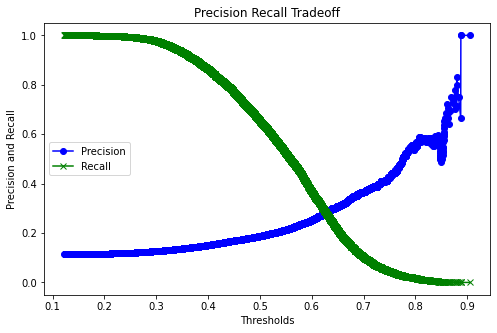

In [ ]:
plt.figure(figsize = (8, 5))
prec, rec, thresh = precision_recall_curve(y_train, y_train_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'center left')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Tradeoff')
plt.show()

Best Threshold=0.498993, G-Mean=0.645


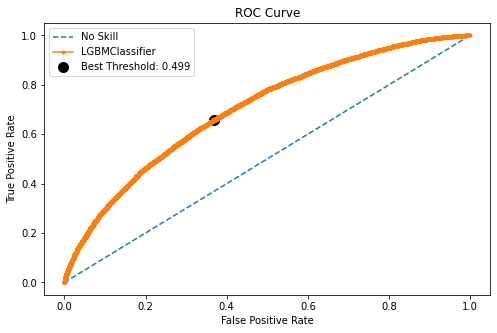

In [ ]:
plt.figure(figsize = (8, 5))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_thresh = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_thresh, gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', alpha = 1, edgecolors = 'k', s = 100,
            label='Best Threshold: '+str(round(best_thresh, 3)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc = 'best')
# show the plot
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_train_prob >= i).astype(bool)
    f1.append(f1_score(y_train, pred))
    acc.append(accuracy_score(y_train, pred))
    prec.append(precision_score(y_train, pred))
    rec.append(recall_score(y_train, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.115425,0.205725,0.114656,1.000000
1,0.15,0.119060,0.206356,0.115052,0.999743
2,0.20,0.132290,0.208739,0.116544,0.999101
3,0.25,0.164874,0.214218,0.120049,0.993705
4,0.30,0.226935,0.224538,0.126845,0.977004
5,0.35,0.318872,0.238783,0.136921,0.932554
6,0.40,0.428895,0.257188,0.151109,0.863052
7,0.45,0.539993,0.277144,0.168993,0.769784
8,0.50,0.636889,0.292409,0.188222,0.654933
9,0.55,0.723278,0.301964,0.212343,0.522482


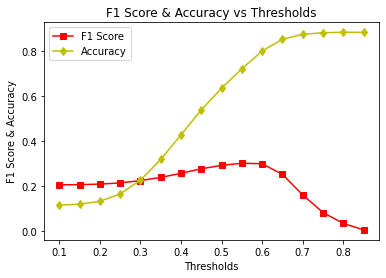

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'r', label = 'F1 Score')
plt.plot(thresh, acc, marker = 'd', c = 'y', label = 'Accuracy')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score & Accuracy')
plt.title('F1 Score & Accuracy vs Thresholds')
plt.legend(loc = 'best')
plt.show()

In [ ]:
y_train_pred = (y_train_prob >= best_thresh).astype(bool)
y_test_pred = (y_test_prob >= best_thresh).astype(bool)
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.6348879306538727
Train Confusion Matrix:
 [[38020 22145]
 [ 2664  5120]] 

Train F1 Score: 0.29216240120973497
Train Precision Score: 0.18778653951953053
Train Recall Score: 0.65775950668037
Train ROC_AUC Score: 0.7028877549739245

Test Accuracy Score: 0.6270732461110539
Test Confusion Matrix:
 [[16199  9586]
 [ 1274  2062]] 

Test F1 Score: 0.2752269087026162
Test Precision Score: 0.1770260989010989
Test Recall Score: 0.61810551558753
Test ROC_AUC Score: 0.6679589719730906


### Different Data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/PGPDSE/Capstone/CSV Files/Diabetes_Preprocessed.csv')
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,preceding_year_visits,number_diab_meds,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Not Available,Referral,1,41,0,1,0,0,0,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,no_med
1,Caucasian,0,15,Emergency,Discharged to home,Emergency,3,59,0,18,0,0,0,"Endocrine, Nutritional, Metabolic, Immunity",Diabetes,"Endocrine, Nutritional, Metabolic, Immunity",9,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,1,1,0,0,1,1,insulin_only
2,AfricanAmerican,0,25,Emergency,Discharged to home,Emergency,2,11,5,13,2,0,1,"Pregnancy, Childbirth",Diabetes,External causes of injury,6,None,None,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,1,0,3,1,0,other_meds
3,Caucasian,1,35,Emergency,Discharged to home,Emergency,2,44,1,16,0,0,0,Infectious and Parasitic,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,1,1,0,0,1,1,insulin_only
4,Caucasian,1,45,Emergency,Discharged to home,Emergency,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,None,None,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,1,1,0,0,2,0,insulin_combo


In [ ]:
df = df.drop('metformin-rosiglitazone', 1)

In [ ]:
X = df.drop(['readmitted'], 1)
y = df['readmitted']
X_dum = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.3, random_state = 0, stratify = y)

In [ ]:
model_cw = XGBClassifier(random_state = 0, n_jobs = -1, scale_pos_weight = 8)
model_cw.fit(X_train, y_train)
sorted(zip(model_cw.feature_importances_, X_train.columns), reverse = True)

[(0.14150496, 'number_inpatient'),
 (0.10246261,
  'discharge_disposition_id_Transferred to another medical facility'),
 (0.034265712, 'preceding_year_visits'),
 (0.026708933, 'number_diagnoses'),
 (0.020559106, 'insulin_treatment_insulin_only'),
 (0.018846521, 'diabetesMed'),
 (0.018422516,
  'discharge_disposition_id_Discharged to home with home health service'),
 (0.018187363, 'age'),
 (0.017495427, 'diag_1_Musculoskeletal System and Connective Tissue'),
 (0.016784102, 'diag_1_Pregnancy, Childbirth'),
 (0.015890999, 'time_in_hospital'),
 (0.015789263, 'number_changes'),
 (0.013984866, 'diag_1_Circulatory'),
 (0.013562798, 'diag_1_Respiratory'),
 (0.013523234, 'diag_2_Neoplasms'),
 (0.012888318, 'diag_2_Diabetes'),
 (0.01276401, 'diag_1_External causes of injury'),
 (0.011814551,
  'discharge_disposition_id_Still patient/referred to this institution'),
 (0.011761614, 'metformin'),
 (0.011599503, 'num_medications'),
 (0.011372775, 'rosiglitazone'),
 (0.011290764, 'diag_3_Infectious an